<a href="https://colab.research.google.com/github/emraankazmi5-coder/deeplearning/blob/main/Assignment_5ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Imports and data load**

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback




In [3]:
# Load your real data
df = pd.read_csv("single_cell.csv")  # first col: CellID, last col: group

# Features: all gene columns except CellID and group
X = df.iloc[:, 1:-1].values.astype("float32")
y = df.iloc[:, -1].values

print("Feature shape:", X.shape)   # e.g. (100, 199)
print("Labels shape:", y.shape)


Feature shape: (100, 199)
Labels shape: (100,)


**2. Encode labels, scale features**

In [4]:
# Encode group labels
le = LabelEncoder()
y_int = le.fit_transform(y)               # 0..K-1
num_classes = len(np.unique(y_int))
y_cat = to_categorical(y_int, num_classes=num_classes)

# Scale gene expression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Replace any NaN / inf
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print("Classes:", num_classes, "->", list(le.classes_))


Classes: 4 -> ['Group1', 'Group2', 'Group3', 'Group4']


**3. Build Keras classifier with latent layer**

In [5]:
input_dim = X_scaled.shape[1]
latent_dim = 2

inputs = Input(shape=(input_dim,), name="input")
x = Dense(128, activation="relu", name="dense_1")(inputs)
latent = Dense(latent_dim, activation="linear", name="latent")(x)
x_cls = Dense(64, activation="relu", name="dense_2")(latent)
outputs = Dense(num_classes, activation="softmax", name="classifier")(x_cls)

model = Model(inputs=inputs, outputs=outputs, name="single_cell_classifier")
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# Model that outputs the latent embedding
latent_model = Model(inputs=inputs, outputs=latent, name="latent_model")


Model: "single_cell_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 199)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,310 (102.77 KB)

 Trainable params: 26,310 (102.77 KB)

 Non-trainable params: 0 (0.00 B)

**4. Callback: save latent embeddings every epoch**

In [6]:
class LatentGifCallback(Callback):
    def __init__(self, x, y_int, latent_model, class_names, out_dir="frames"):
        super().__init__()
        self.x = x
        self.y_int = y_int
        self.latent_model = latent_model
        self.class_names = class_names
        self.out_dir = out_dir
        os.makedirs(self.out_dir, exist_ok=True)
        self.cmap = plt.cm.get_cmap("tab10", len(class_names))

    def on_epoch_end(self, epoch, logs=None):
        # Compute latent embedding
        z = self.latent_model.predict(self.x, verbose=0)  # (N, 2)

        plt.figure(figsize=(5, 4))
        for i, cls in enumerate(self.class_names):
            mask = self.y_int == i
            plt.scatter(
                z[mask, 0],
                z[mask, 1],
                s=30,
                color=self.cmap(i),
                label=str(cls),
                alpha=0.8
            )

        plt.title(f"Epoch {epoch+1}")
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.legend(fontsize=8)
        plt.tight_layout()

        frame_path = os.path.join(self.out_dir, f"frame_{epoch:03d}.png")
        plt.savefig(frame_path, dpi=120)
        plt.close()


In [7]:
latent_cb = LatentGifCallback(
    x=X_scaled,
    y_int=y_int,
    latent_model=latent_model,
    class_names=le.classes_,
    out_dir="frames"
)


/tmp/ipython-input-605268676.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.cmap = plt.cm.get_cmap("tab10", len(class_names))


**5. Train and save frames**

In [8]:
epochs = 50
history = model.fit(
    X_scaled,
    y_cat,
    epochs=epochs,
    batch_size=32,
    shuffle=True,
    callbacks=[latent_cb],
    verbose=1
)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.3425 - loss: 1.3624
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5737 - loss: 1.1877
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7387 - loss: 1.0270
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9171 - loss: 0.8475
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9076 - loss: 0.6830
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9291 - loss: 0.5616
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9785 - loss: 0.3927
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9908 - loss: 0.2696
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9845 - loss: 0.1709
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 0.1018
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0695
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - lo

**6. Create GIF of latent evolution**

/tmp/ipython-input-2511132818.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in frame_files]


GIF created: latent_training.gif


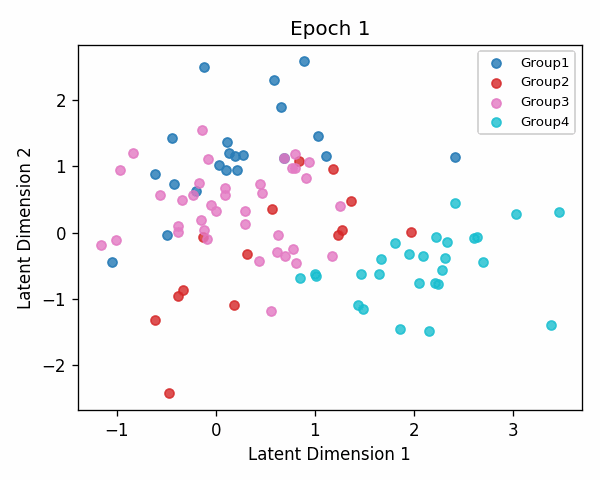

In [12]:
frames_dir = "frames"
gif_path = "latent_training.gif"

frame_files = sorted(
    [os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith(".png")]
)

images = [imageio.imread(f) for f in frame_files]
imageio.mimsave(gif_path, images, duration=0.4)

print("GIF created:", gif_path)

from IPython.display import Image, display

gif_path = "latent_training.gif"   # same name as in your code
display(Image(filename=gif_path))

